In [2]:
# those modules are almost always imported when working with model data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!

import netCDF4
import os
from glob import glob
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pickle as pickle

## First load Gravity CSV for sampling

In [2]:
import pandas as pd
from glob import glob
def importOIBgrav(basedir, timedir):
    # datadir = 'IGGRV1B/temp'
    # infile = 'IGGRV1B_20091104_13100500_V016'
    # infile = 'IGGRV1B_20091031_11020500_V016'
    # infile = 'IGGRV1B_20091116_15124500_V016'
    suffix = '.txt'
    pattern = os.path.join(basedir, timedir, 'IGGRV1B_20161114_11243000_V017*' + suffix)
    infile = sorted(glob(pattern))  # , key=alphanum_key)

    ### Read ascii file as csv
    # metadata ends on line 69, column names on line 70
    headers = (
        'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY', 'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR',
        'INTCOR',
        'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO')
    # print "Reading gravity file: %s" % infile[0] + suffix %TODO why did I think this would be a list?
    print("Reading gravity file: %s" % infile[0] + suffix)
    df = pd.read_csv(infile[0], delimiter=r"\s+", header=None, names=headers, skiprows=70)
    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    # df['ENVIRO'] = df.columns[[19]]
    # df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)

    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE * 1e5) + df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
    df.drop(['DATETIME'], axis=1, inplace=True)
    df = df.set_index('iunix')
    return df

basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
timedir = 2016
grav = importOIBgrav(os.path.join(basedir, datadir), str(timedir))


Reading gravity file: /Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2016/IGGRV1B_20161114_11243000_V017.txt.txt


In [3]:
grav.head()

,LAT,LONG,DATE,DOY,TIME,FLT,PSX,PSY,WGSHGT,FX,FY,FZ,EOTGRAV,FACOR,INTCOR,FAG070,FAG100,FAG140,FLTENVIRO,UNIX
iunix,,,,,,,,,,,,,,,,,,,,
2016-11-14 11:24:30.000,-53.004590,-70.845986,2016-11-14,319,41070.0,621,-3929452.26,1364844.81,50.57,5.01,-15.79,981296.93,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:30.500,-53.004590,-70.845986,2016-11-14,319,41070.5,621,-3929452.26,1364844.81,50.57,4.52,-15.33,981297.13,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.000,-53.004590,-70.845985,2016-11-14,319,41071.0,621,-3929452.27,1364844.82,50.56,3.46,-14.49,981297.14,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.500,-53.004590,-70.845985,2016-11-14,319,41071.5,621,-3929452.27,1364844.83,50.55,2.05,-13.60,981296.95,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:32.000,-53.004589,-70.845985,2016-11-14,319,41072.0,621,-3929452.28,1364844.85,50.54,0.73,-13.01,981296.61,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09


## ANTGG

In [4]:
basedir = '/Users/dporter/Documents/data_local/'
datadir = 'Antarctica/Geophysical/Scheinert_2016/'
suffix = '.nc'

pattern = os.path.join(basedir, datadir, 'antgg*' + suffix)
filenames = sorted(glob(pattern))  # , key=alphanum_key)
print(filenames)

nc_fid = netCDF4.Dataset(filenames[0], 'r')
# nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)
nc_vars = [var for var in nc_fid.variables]
nc_dims = [dim for dim in nc_fid.dimensions]
# print nc_vars
# print nc_dims

for vnum, var in enumerate(nc_vars, start=0):
    if var not in nc_dims:
        ###
#         print nc_fid.variables[var].dimensions
        try:
            globals()[var] = nc_fid.variables[var][:]#.flatten()
            print('Found %i %s records in %s' % (globals()[var].size, str(var), str(filenames[0])))
        except:
            print('No %s found in file.' % (str(var)))
            globals()[var] = np.full([333, ], np.nan)
            # print 'Original shape of %s: %s' % (nc_vars[vnum], globals()[var].shape)

['/Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc']
Found 444889 longitude records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 latitude records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 ellipsoidal_height records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 orthometric_height records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 free_air_anomaly records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 accuracy_measure records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc
Found 444889 bouguer_anomaly records in /Users/dporter/Documents/data_local/Antarctica/Geophysical/Scheinert_2016/antgg2015.nc


In [5]:
print(type(np.array(ellipsoidal_height)))
print(len(ellipsoidal_height))
print(ellipsoidal_height[:])
print(type(latitude))
# plt.plot(ellipsoidal_height)

<class 'numpy.ndarray'>
667
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
<class 'numpy.ma.core.MaskedArray'>


In [6]:
# Make an empty 'dictionary'... place the 3 grids in it.
FAG = {}
FAG['lats']=latitude
FAG['lons']=longitude
FAG['fag']=np.array(free_air_anomaly)
# Save (i.e. pickle) the data for later use
# This saves the variable TOPO (with all its contents) into the file: topo.p
# pickle.dump(FAG, open('antgg2015_fag.p','wb'))
np.ma.dump(FAG, open('antgg2015_fag.p','wb'))
FAG

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.ma.dump is deprecated, use pickle.dump instead
  if __name__ == '__main__':


{'lats': masked_array(
   data=[[-48.49868444, -48.5558271 , -48.61290439, ..., -48.61290439,
          -48.5558271 , -48.49868444],
         [-48.5558271 , -48.61307673, -48.67026115, ..., -48.67026115,
          -48.61307673, -48.5558271 ],
         [-48.61290439, -48.67026115, -48.72755283, ..., -48.72755283,
          -48.67026115, -48.61290439],
         ...,
         [-48.61290439, -48.67026115, -48.72755283, ..., -48.72755283,
          -48.67026115, -48.61290439],
         [-48.5558271 , -48.61307673, -48.67026115, ..., -48.67026115,
          -48.61307673, -48.5558271 ],
         [-48.49868444, -48.5558271 , -48.61290439, ..., -48.61290439,
          -48.5558271 , -48.49868444]],
   mask=False,
   fill_value=1e+20), 'lons': masked_array(
   data=[[ -45.        ,  -44.913841  ,  -44.82742287, ...,   44.82742287,
            44.913841  ,   45.        ],
         [ -45.086159  ,  -45.        ,  -44.91358109, ...,   44.91358109,
            45.        ,   45.086159  ],
         [ 

In [7]:
# Make an empty 'dictionary'... place the 3 grids in it.
BOU = {}
BOU['lats']=latitude
BOU['lons']=longitude
BOU['bou']=np.array(bouguer_anomaly)
BOU['ell']=np.array(ellipsoidal_height)
# Save (i.e. pickle) the data for later use
# This saves the variable TOPO (with all its contents) into the file: topo.p
pickle.dump(BOU, open('antgg2015_bouger.p','wb'))
BOU['ell']

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

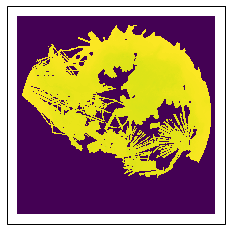

In [8]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.SouthPolarStereo())
# ax.set_extent([-180, 180, -90, -60])
plt.pcolormesh(longitude, latitude, BOU['bou'], transform=ccrs.PlateCarree())
# ax.coastlines()
plt.show()

### using XARRAY

In [3]:
basedir = '/Users/dporter/Documents/data_local/'
datadir = 'Antarctica/Geophysical/Scheinert_2016/'
suffix = '.nc'

pattern = os.path.join(basedir, datadir, 'antgg*' + suffix)
filenames = sorted(glob(pattern))  # , key=alphanum_key)

ds = xr.open_dataset(filenames[0])
ds


<xarray.Dataset>
Dimensions:             (x: 667, y: 667)
Coordinates:
  * x                   (x) int32 -3330 -3320 -3310 -3300 ... 3310 3320 3330
  * y                   (y) int32 3330 3320 3310 3300 ... -3310 -3320 -3330
Data variables:
    longitude           (y, x) float64 ...
    latitude            (y, x) float64 ...
    crs                 int32 ...
    ellipsoidal_height  (y, x) float64 ...
    orthometric_height  (y, x) float64 ...
    free_air_anomaly    (y, x) float32 ...
    accuracy_measure    (y, x) float32 ...
    bouguer_anomaly     (y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Antarctic Gravity Grid
    institution:  TU Dresden
    source:       http://dx.doi.org/10.1594/PANGAEA.848168
    comment:      Reference: Scheinert et al. (2015)

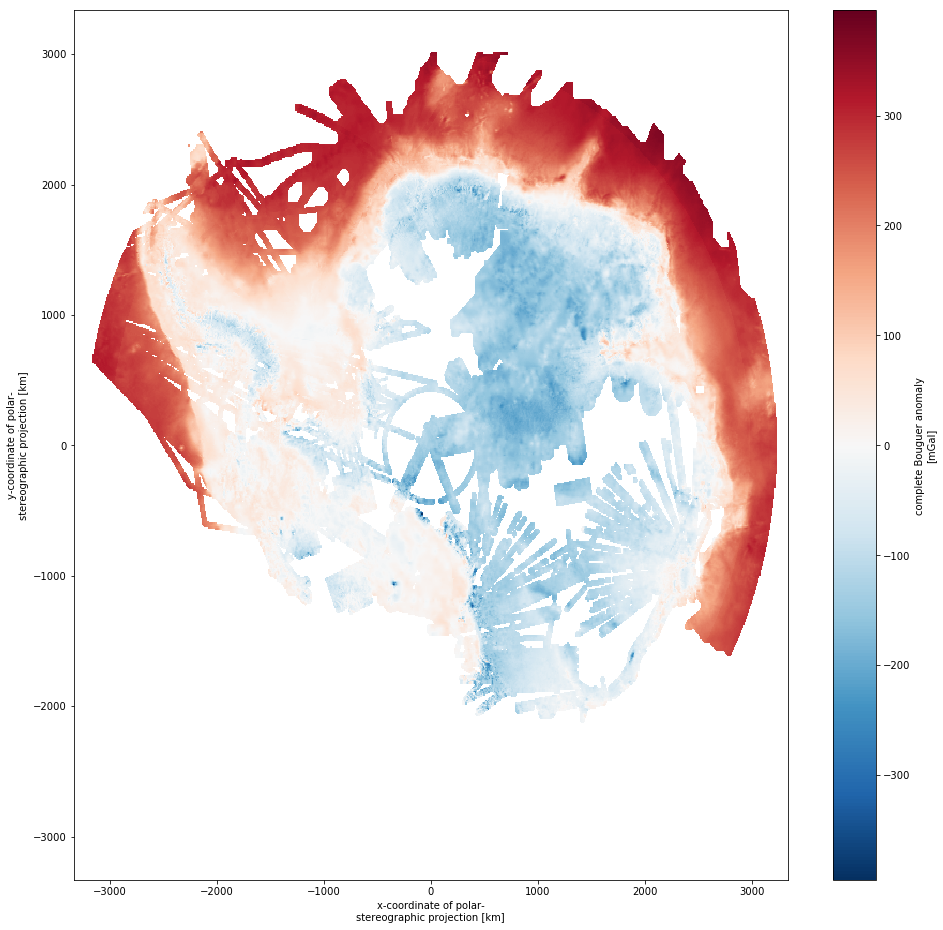

In [6]:
fig = plt.subplots(figsize=(16, 16))
ds['bouguer_anomaly'].plot()

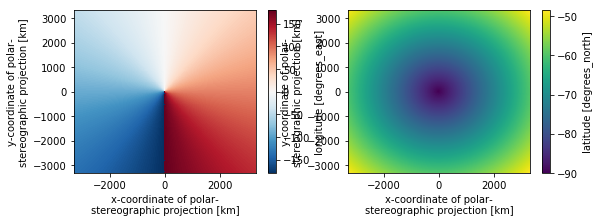

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,3))
ds.longitude.plot(ax=ax1);
ds.latitude.plot(ax=ax2);

In [29]:
# plt.figure(figsize=(7,2));
# ax = plt.axes(projection=ccrs.PlateCarree());
# ds['free_air_anomaly'].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
#                           x='longitude', y='latitude', add_colorbar=False);
# ax.coastlines();
# plt.tight_layout();

In [32]:
ds = ds.set_index(latdim='latitude')
ds = ds.set_index(londim='longitude')

In [35]:
ds.sel(latdim=-70, londim=0)['free_air_anomaly'].values #.diagonal()

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [33]:
ds.sel(latdim=[-70,-71,-72, -73, -74, -75, -76, -77, -78, -79,-80,-81,-82], 
           londim=[0,1,2,3,4,5,6,7,8,9,10,11,12])['free_air_anomaly'].values #.diagonal()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
grav['test'] =  np.nan
test = np.full([grav.shape[0], ], np.nan)
lat_sample = np.full([grav.shape[0], ], np.nan)
lon_sample = np.full([grav.shape[0], ], np.nan)

for i in range(0, grav.shape[0], 50):
# for i in range(0, 30000, 50):
#     ii, jj = get_closest_MAR_cell(ds, grav['LAT'][i], grav['LONG'][i])
#     print('ii: {}\njj: {}'.format(ii, jj))
    lat_sample[i] = ds['latitude'][ii,jj].values
    lon_sample[i] = ds['longitude'][ii,jj].values
#     print(lat_sample[i])
#     test[i] = ds['bouguer_anomaly'].isel(x=jj, y=ii).values
    grav['test'].iloc[i] = ds['ellipsoidal_height'][ii, jj].values
#     print(test[i])

#     print(ds['latitude'].isel(x=jj, y=ii).values.flatten()[0], ds['longitude'].isel(x=jj, y=ii).values)

In [ ]:
# plt.plot(test)
grav['test'].plot()

In [15]:
grav['test'].describe()

KeyError: 'test'

In [16]:
plt.plot(lon_sample, lat_sample, 'k,')

NameError: name 'lon_sample' is not defined

In [17]:
plt.scatter(lon_sample, lat_sample, c=grav['ANTGG'], marker='s')
plt.colorbar()

NameError: name 'lon_sample' is not defined

In [18]:
np.nanmin(lat_sample)

NameError: name 'lat_sample' is not defined

In [19]:
ds.latitude.shape

AttributeError: 'Dataset' object has no attribute 'latitude'

In [87]:
# ds.sel(latitude=-79)

In [88]:
np.sqrt(841)

29.0